In [6]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pyinterp

In [2]:
train_path = "/Users/sebastien/Documents/Projects/ssh_mapping/dc_obs/2020a_SSH_mapping_NATL60_envisat.nc"

In [3]:
df_train = xr.open_dataset(train_path)
df_train

<xarray.Dataset> Size: 3MB
Dimensions:      (time: 49646, cycle: 1)
Coordinates:
  * time         (time) datetime64[ns] 397kB 2012-10-01T00:45:50.676369 ... 2...
Dimensions without coordinates: cycle
Data variables:
    lon          (time) float64 397kB ...
    lat          (time) float64 397kB ...
    x_al         (time) float32 199kB ...
    ncycle       (time, cycle) timedelta64[ns] 397kB ...
    model_index  (time) float32 199kB ...
    ssh_obs      (time) float64 397kB ...
    ssh_model    (time) float64 397kB ...
    nadir_err    (time) float64 397kB ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    project:                   SWOT
    date_created:              2018-10-12T12:41:35Z
    date_modified:             2018-10-12T12:41:35Z
    keywords_vocabulary:       NASA
    references:                Gaultier, L., C. Ubelmann, and L.-L. Fu, 2016:...

In [4]:
df_train.values

<bound method Mapping.values of <xarray.Dataset> Size: 3MB
Dimensions:      (time: 49646, cycle: 1)
Coordinates:
  * time         (time) datetime64[ns] 397kB 2012-10-01T00:45:50.676369 ... 2...
Dimensions without coordinates: cycle
Data variables:
    lon          (time) float64 397kB ...
    lat          (time) float64 397kB ...
    x_al         (time) float32 199kB ...
    ncycle       (time, cycle) timedelta64[ns] 397kB ...
    model_index  (time) float32 199kB ...
    ssh_obs      (time) float64 397kB ...
    ssh_model    (time) float64 397kB ...
    nadir_err    (time) float64 397kB ...
Attributes: (12/26)
    description:               SWOT fixed grid
    corresponding_grid:        
    title:                     Altimeter like data simulated by SWOT simulator
    keywords:                  check keywords
    Conventions:               CF-1.6
    summary:                   SWOT grid data produced
    ...                        ...
    geospatial_lon_units:      degrees_east
    p

In [47]:
lon1d = df_train["lon"].values
lat1d = df_train["lat"].values
time1d = df_train["time"].values
ssh1d = df_train["ssh_model"].values


In [48]:
time1d_days = (time1d - time1d[0]) / np.timedelta64(1,'D')
time1d_days

array([0.00000000e+00, 1.14440972e-05, 2.09808333e-05, ...,
       3.64572163e+02, 3.64572163e+02, 3.64572193e+02])

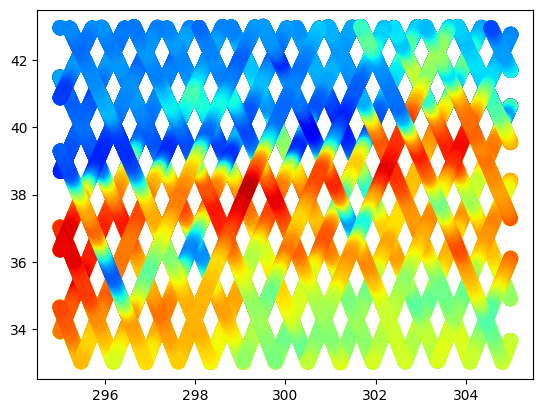

In [49]:
plt.scatter(df_train["lon"], df_train["lat"], c=df_train["ssh_model"],cmap="jet", s=100)

In [50]:
dlon = dlat = 1/10
dtime = 1 #days
lon = np.arange(lon1d.min(),lon1d.max(),dlon)
lat = np.arange(lat1d.min(),lat1d.max(),dlat)
time = np.arange(time1d_days.min(),time1d_days.max(),dtime)
time3d,lat3d,lon3d = np.meshgrid(time,lat,lon,indexing='ij')
lat2d,lon2d = np.meshgrid(lat,lon,indexing='ij')


In [18]:
np.max(time1d)

numpy.datetime64('2013-09-30T14:29:48.164162000')

In [82]:
# Load your dataset
df_train = xr.open_dataset(train_path)

# Extract the 1D arrays
lon1d = df_train["lon"].values
lat1d = df_train["lat"].values
time1d = df_train["time"].values
ssh1d = df_train["ssh_model"].values

# Create a regular grid for lon and lat
lon_min, lon_max = 295,305
lat_min, lat_max = 33,43

# Define your desired resolution (number of points) for the new grid
num_lon = 100  # for example, 100 points
num_lat = 100  # for example, 100 points

lon_regular = np.linspace(lon_min, lon_max, num_lon)
lat_regular = np.linspace(lat_min, lat_max, num_lat)
lon_grid, lat_grid = np.meshgrid(lon_regular, lat_regular)

# Define the desired time resolution and create a regular time grid
time_min, time_max = np.datetime64('2012-10-01'), np.datetime64('2013-10-01')
# Define your desired time resolution (e.g., '1H' for hourly, '1D' for daily, etc.)
time_resolution = '1D'
time_regular = np.arange(time_min, time_max, np.timedelta64(1, 'D'))

# Prepare a container for the new grid data
ssh_grid = np.empty((len(time_regular), num_lat, num_lon))

# Interpolate data for each time step
for t_idx, time in enumerate(time_regular):
    # Mask for the current time step within a tolerance
    time_tol = np.timedelta64(24, 'h')  # Adjust this tolerance as needed
    mask = np.abs(time1d - time) <= time_tol


    mesh = pyinterp.RTree()
    
    ssh_values = ssh1d[mask]
    lon_values = lon1d[mask]
    lat_values = lat1d[mask]

    mesh.packing(
        np.vstack((lon_values, lat_values)).T,
        ssh_values)
    
    idw_eta, neighbors = mesh.inverse_distance_weighting(
        np.vstack((lon_grid.ravel(), lat_grid.ravel())).T,
        within=True,  # Extrapolation is forbidden
        radius=10000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0)
    ssh_grid[t_idx, :, :] = idw_eta.reshape(lon_grid.shape)
    

# Create a new xarray dataset
ds = xr.Dataset(
    {
        "ssh_model": (["time", "lat", "lon"], ssh_grid)
    },
    coords={
        "time": time_regular,
        "lat": lat_regular,
        "lon": lon_regular
    }
)

# Save the new dataset if needed
# ds.to_netcdf("regridded_ssh_model.nc")

print(ds)


<xarray.Dataset> Size: 29MB
Dimensions:    (time: 365, lat: 100, lon: 100)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2012-10-01 2012-10-02 ... 2013-09-30
  * lat        (lat) float64 800B 33.0 33.1 33.2 33.3 ... 42.7 42.8 42.9 43.0
  * lon        (lon) float64 800B 295.0 295.1 295.2 295.3 ... 304.8 304.9 305.0
Data variables:
    ssh_model  (time, lat, lon) float64 29MB nan nan nan nan ... nan nan nan nan


/var/folders/x5/b7338gqd1016m84cvky6tplh0000gn/T/ipykernel_11286/1419489719.py:58: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds = xr.Dataset(


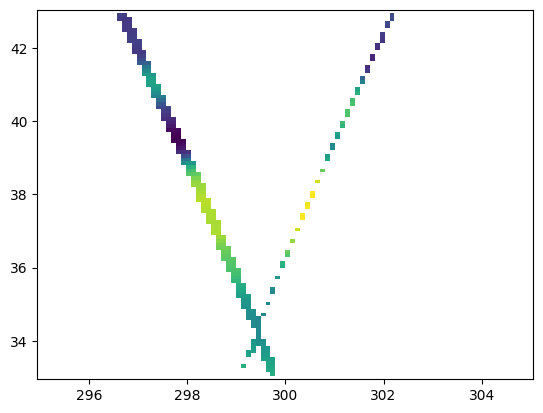

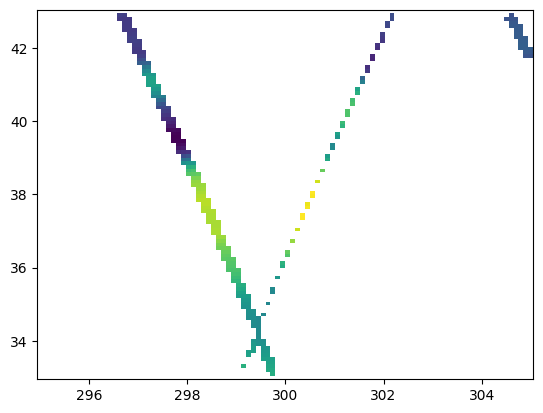

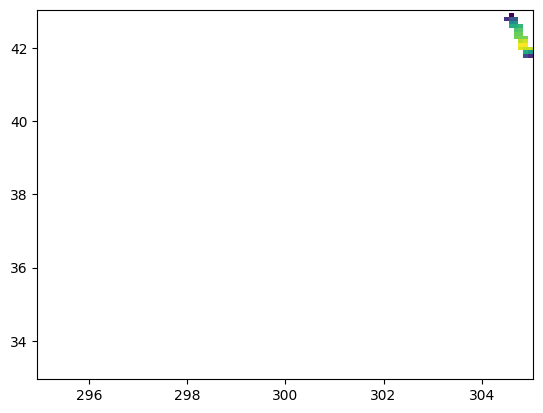

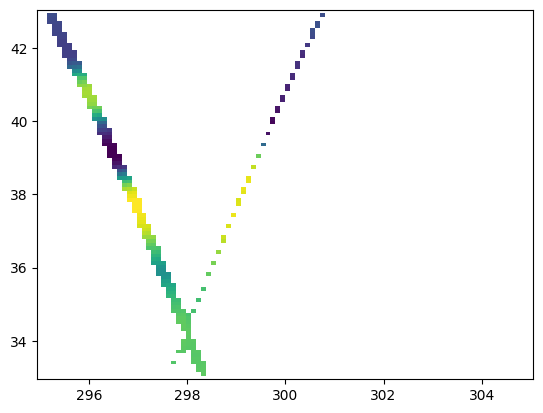

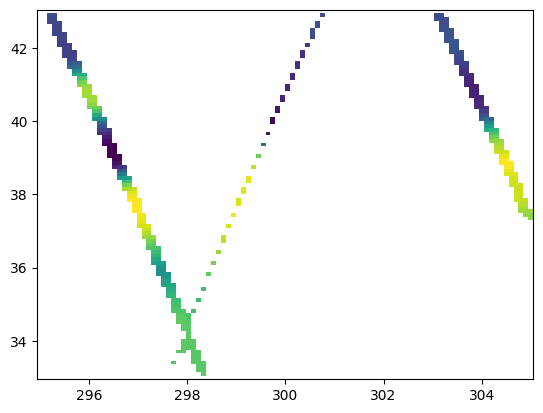

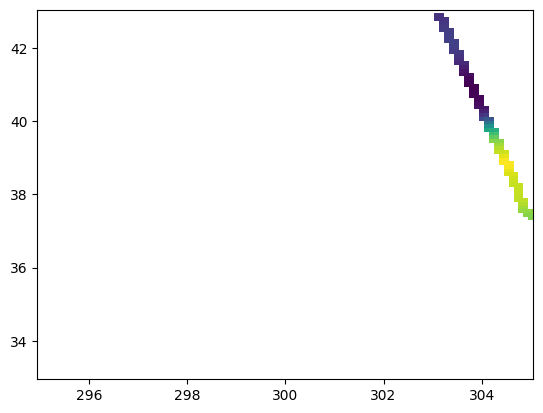

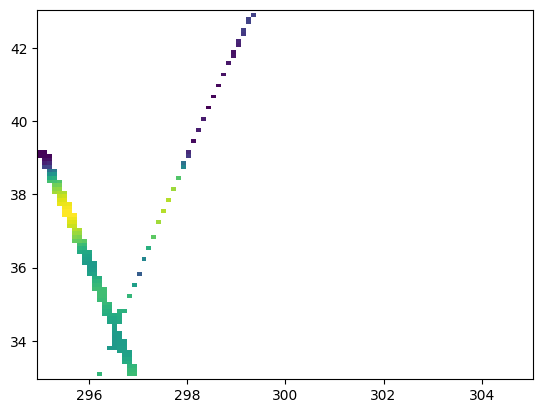

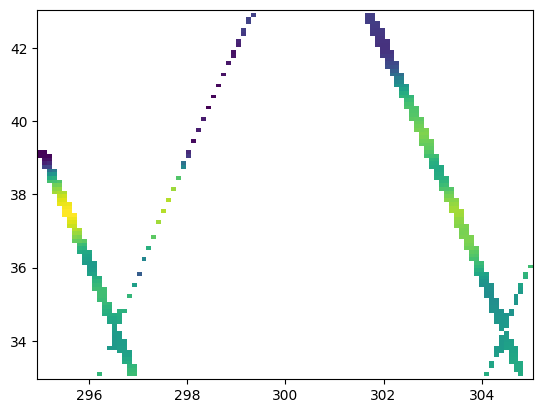

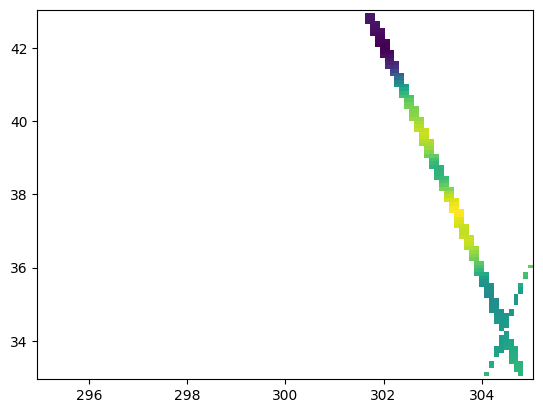

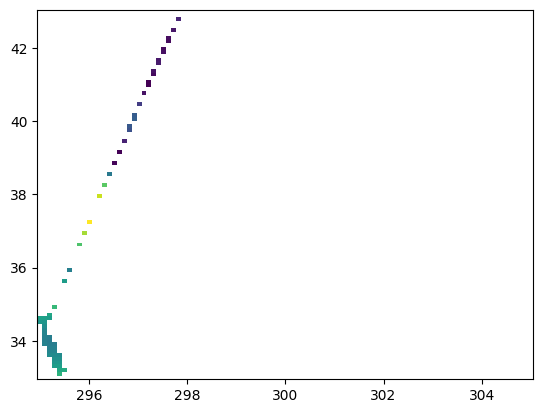

In [83]:
for t in range(10):

    plt.figure()
    plt.pcolormesh(ds.lon,ds.lat,ds.ssh_model[t])
    plt.show()


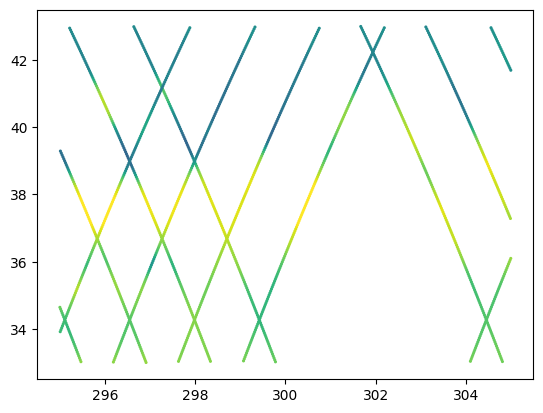

In [68]:
df_sel = df_train.squeeze().sel(time=slice('2012-10-01','2012-10-10'))

plt.scatter(df_sel["lon"], df_sel["lat"], c=df_sel["ssh_model"],cmap="viridis", s=1.5,vmin=-1,vmax=1)
# ds.ssh_model[:10].mean(axis=0).plot(vmin=-1,vmax=1)
plt.savefig("test.png")

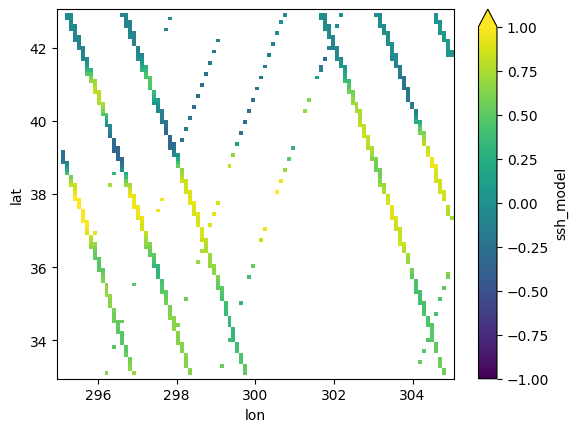

In [67]:
#plt.scatter(df_sel["lon"], df_sel["lat"], c=df_sel["ssh_model"],cmap="viridis", s=1.5,vmin=-1,vmax=1)
ds.ssh_model[:10].mean(axis=0).plot(vmin=-1,vmax=1)

In [37]:
slice('2012-10-01','2012-10-10')

slice('2012-10-01', '2012-10-10', None)

1460

In [91]:
!conda search pyinterp --channel conda-forge

Loading channels: done
# Name                       Version           Build  Channel             
pyinterp                       0.0.4  py36hcd971b2_1  conda-forge         
pyinterp                       0.0.4  py37hcd971b2_1  conda-forge         
pyinterp                       0.0.5  py36hcd971b2_0  conda-forge         
pyinterp                       0.0.5  py36hcd971b2_1  conda-forge         
pyinterp                       0.0.5  py37hcd971b2_0  conda-forge         
pyinterp                       0.0.5  py37hcd971b2_1  conda-forge         
pyinterp                       0.0.6  py36hcd971b2_0  conda-forge         
pyinterp                       0.0.6  py37hcd971b2_0  conda-forge         
pyinterp                       0.0.6  py38hcd971b2_0  conda-forge         
pyinterp                       0.0.7  py36hcd971b2_0  conda-forge         
pyinterp                       0.0.7  py37hcd971b2_0  conda-forge         
pyinterp                       0.0.7  py38hcd971b2_0  conda-forge         
py

In [94]:
!pip install pyinterp==0.1.1

ERROR: Could not find a version that satisfies the requirement pyinterp==0.1.1 (from versions: 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.2.0, 0.3.1, 0.4.0, 0.5.1, 0.8.0, 0.12.0, 0.13.0, 0.14.0, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 2022.9.0, 2022.9.1, 2022.10.0, 2022.10.1, 2023.1.0, 2023.2.0, 2023.2.1, 2023.5.0, 2023.10.0, 2023.10.1, 2023.10.2, 2023.11.0, 2024.1.0, 2024.2.0, 2024.3.0)
ERROR: No matching distribution found for pyinterp==0.1.1


In [96]:
!conda install pyinterp -c conda-forge -y

Channels:
 - conda-forge
 - defaults
Platform: osx-64
Solving environment: done

## Package Plan ##

  environment location: /Users/sebastien/miniconda3/envs/sshmapping

  added / updated specs:
    - pyinterp


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    aws-c-auth-0.7.22          |       h26aba2d_2          91 KB  conda-forge
    aws-c-cal-0.6.14           |       hb0e519c_1          38 KB  conda-forge
    aws-c-common-0.9.19        |       hfdf4475_0         204 KB  conda-forge
    aws-c-compression-0.2.18   |       hb0e519c_6          18 KB  conda-forge
    aws-c-event-stream-0.4.2   |      hc5e814a_12          46 KB  conda-forge
    aws-c-http-0.8.1           |      ha6e9f73_17         159 KB  conda-forge
    aws-c-io-0.14.8            |       hf69683f_5         135 KB  conda-forge
    aws-c-mqtt-0.10.4          |       h76e2169_4         136 KB  conda-forge
    aws-c-s3-0.5.9  

In [ ]:
y
